**skin cancer data analysis&classification with CNN**



The images come from the **HAM10000 ("Human Against Machine with 10000 training images")** dataset. It consists of 10015 dermatoscopic images which are released as a training set for academic machine learning purposes and are publicly available through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts. 

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**




# Step 1 : Auxiliary steps

 importing essential python libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, requests, tarfile, io, itertools
from PIL import Image
from time import time
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import tensorflow as tf
print (tf.__version__)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi


1.15.0


Using TensorFlow backend.


Found GPU at: /device:GPU:0
Tue Feb 11 20:52:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |    111MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [2]:
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/My Drive'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass
sys.path.append(base_working_dir)
!mkdir -p drive
!google-drive-ocamlfuse drive
print(base_working_dir)
from DL.exercise_functions import *

base_working_dir = os.path.join(base_working_dir, 'Skin_Cancer_class')

if not os.path.exists(base_working_dir):
    os.makedirs(base_working_dir)
    
print (base_working_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/bin/bash: google-drive-ocamlfuse: command not found
/content/drive/My Drive
/content/drive/My Drive/Skin_Cancer_class


# Step 2 : Making Dictionary of labels

In [0]:
# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

# Step 3 : Reading & Processing data



I convert the categorical column cell_type_idx where have categorize the lesion type in to codes from 0 to 6

In [0]:
try:
    skin_df = pd.read_csv(os.path.join(base_working_dir, 'HAM10000_metadata.csv'))
except:
    # download images from a shared archive 
    url = 'https://drive.google.com/uc?authuser=0&id=1jdCVOmeJXI6bhWIfFVL7RqwyuOHiRjaE&export=download'
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(base_working_dir, 'HAM10000_metadata.csv'), 'wb').write(r.content)
    skin_df = pd.read_csv(os.path.join(base_working_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

Plot a table where each line references image and corresponding data (localization, lesion, consensus, sex, ...).And use this table to analyze distribution of various variables.

In [0]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


# Step 5 : Statistical Analysis of the Data

Look at different features of the **HAM10000_metadata.csv** dataset, their distributions and counts.<br>
Use the method **value_counts()** of the pandas datasheet **skin_df** to plot the following distributions:
1. the type of the cancer 
2. the validation method used 
3. the location of the cancer on the body
4. the age
5. the sex
6. the prevalence of each cancer type against the age. Use the **scatterplot** function from the **seaborn** package. 






plot the histogram of the 'cell_type' occurences first. 


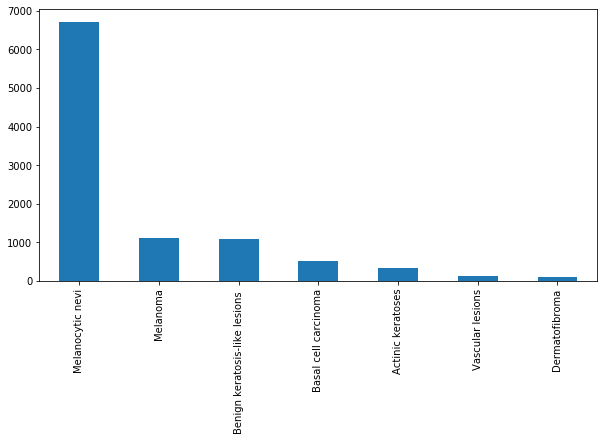

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

### **Plot the frequency of different validation methods.** <br> 
The Technical Validation has been done by either of the following methods:<br>
**1. Histopathology(Histo):**
**2. Confocal:** In-vivo reflectance confocal microscope
**3. Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists  accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions. **4. Consensus:** For typical benign cases without histopathology or followup biologists provide an expert consensus (labeled consensus only if both experts independently gave the same unequivocal diagnosis.


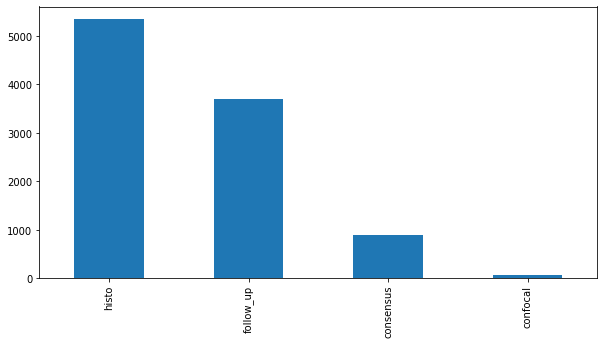

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['dx_type'].value_counts().plot(kind='bar', ax=ax1)

 Back are the most heavily compromised regions of skin cancer




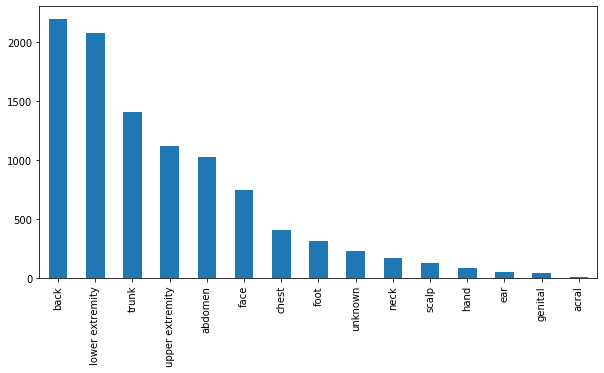

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['localization'].value_counts().plot(kind='bar', ax=ax1)

### **. Check the distribution of Age**

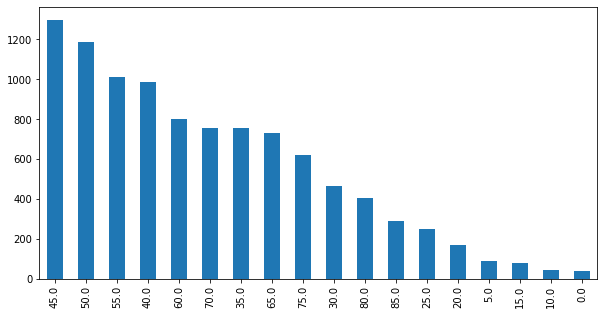

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['age'].value_counts().plot(kind='bar', ax=ax1)

### **Q. Plot the distribution of males and females.**

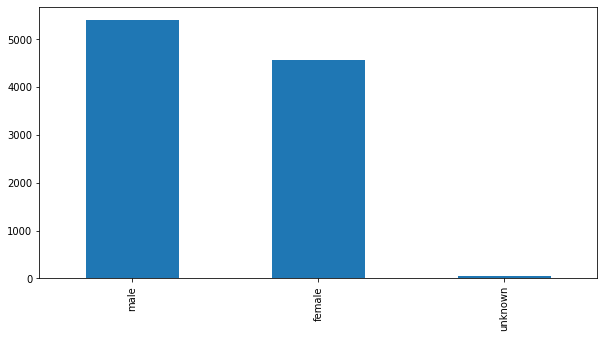

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['sex'].value_counts().plot(kind='bar', ax=ax1)

### ** Visualize the age-wise distribution of skin cancer types.**<br>


Young people(under 20) are unlikely to suffer from actinic keratoses, dermatofibroma and basal cell carcinoma


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


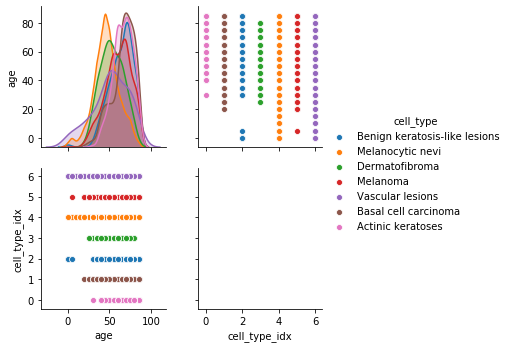

In [0]:
sns.pairplot(skin_df, hue = 'cell_type')

# Step 6: Loading the images



1) High-resolution images and the relief of the lesion are important featuers for dermatologists to examine visually skin moles.

 

2) Processing big data is time-costly. In this session downsampled images will used instead of original size.





In [0]:
# select below to work with small images or large images

if True:   
    # use small 150x100 images first
    url = 'https://drive.google.com/uc?authuser=0&id=1--oGquD0y48lW-6WRz5ldM1rGqbJKOez&export=download'
    tgz_name = 'HAM10000_images_150x100.tar'
else:      
    # high resolution is important for dermatologists to assess skin moles visually
    # interested in training on larger images 300x250?  
    # Download this file manually to your Google drive first
    # https://drive.google.com/uc?authuser=0&id=1-4fKAGB_rpzp6eFFEzAYOVJgXtkDzLoW&export=download
    url = ''
    tgz_name = 'HAM10000_images_300x225.tar'

In [6]:
try:
    t = tarfile.open(os.path.join(base_working_dir,tgz_name), 'r')
    print ('file %s found'%os.path.join(base_working_dir,tgz_name))
except:
    # download images from a shared archive 
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(base_working_dir,tgz_name), 'wb').write(r.content)
    print ('%s downloaded'%os.path.join(base_working_dir,tgz_name))

file /content/drive/My Drive/Skin_Cancer_class/HAM10000_images_150x100.tar found


The images will be decompressed and loaded into the datasheet from the downloaded archive.  Loading 10000 images takes several seconds.

In [7]:
# read each image and assign it as a cell content
t = tarfile.open(os.path.join(base_working_dir,tgz_name), 'r')

t1 = time()
skin_df['image'] = skin_df['image_id'].map(lambda x: np.asarray(Image.open(io.BytesIO(t.extractfile(os.path.join('HAM10000_images',x+'.jpg')).read()))))
print ('%d images read in %d seconds.'%(len(skin_df['image']),time()-t1))


10015 images read in 6 seconds.


Now  10015 colour images with RGB channels of size 100x75 loaded into the computer memory.

Check a few sample images to see each cancer type

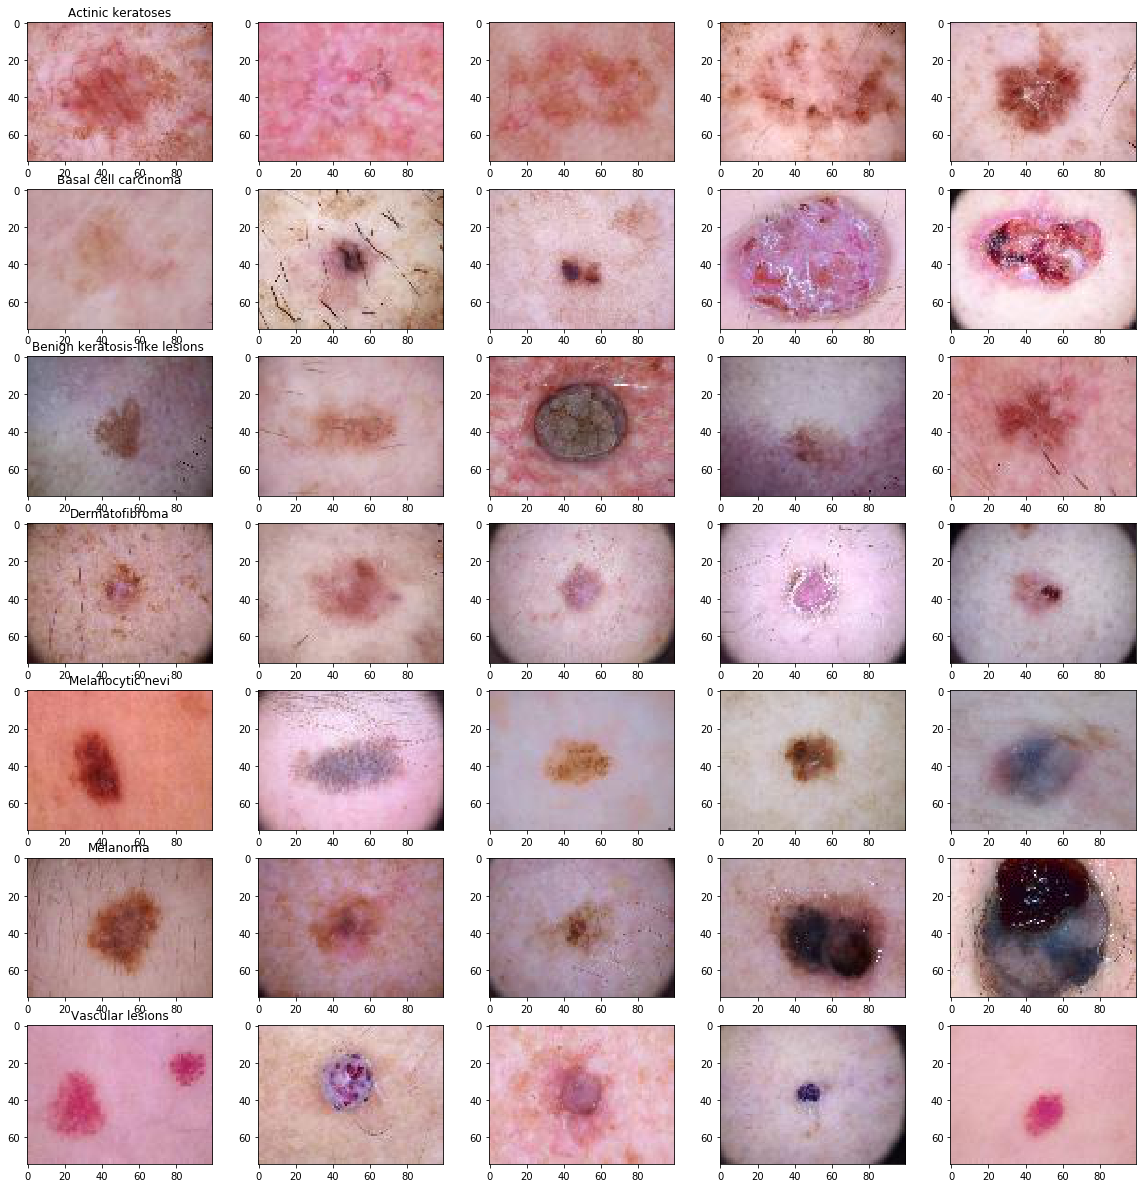

In [8]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_axs, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
      c_axs.imshow(c_row['image'])


# Step 7 : Dataset preparation
Convert the target (the **cell_type_idx** column of the datasheet) into the one-hot encoding format. Recall, that one-hot encoding allows having several output neurons, with only one out of these firing one. Use the keras **to_categorical** function for the conversion.

Split the dataset into training and testing set of 80:20 ratio. The testing set will not be used during the training but rather in the end of this script to test the accuracy. The training set will be further split into training and validation.

In [9]:
features = np.asarray(skin_df['image'])
target = to_categorical(skin_df['cell_type_idx'], num_classes = 7)
b=[]
for i in range(features.size):
  b.append(features[i])
feature=np.array(b)
x_train, x_test, y_train, y_test =train_test_split(feature,target, test_size=0.20, random_state=666)
print(x_test.shape)

(2003, 75, 100, 3)


# Step 8 : Normalization


Normalize the x_train, x_test arrays by substracting the mean values and dividing by the standard deviation.

In [0]:
def standardize(img):
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    return img
standardized_images=[]
for img in x_train:
    r_channel = standardize(img[:,:,0])
    g_channel = standardize(img[:,:,1])
    b_channel = standardize(img[:,:,2])
    normalized_image = np.stack([r_channel, g_channel, b_channel], axis=-1)
    standardized_images.append(normalized_image)
x_train= np.array(standardized_images)
standardized_images=[]
for img in x_test:
    r_channel = standardize(img[:,:,0])
    g_channel = standardize(img[:,:,1])
    b_channel = standardize(img[:,:,2])
    normalized_image = np.stack([r_channel, g_channel, b_channel], axis=-1)
    standardized_images.append(normalized_image)
x_test= np.array(standardized_images)


# Step 10 : Splitting training and validation

In [0]:
x_train, x_validate, y_train, y_validate =train_test_split(x_train,y_train, test_size=0.10, random_state=66)

In [0]:
x_train, x_validate, y_train, y_validate =train_test_split(x_train,y_train, test_size=0.10, random_state=666)

# Step 11: Model Building 
# CNN
Use the Keras **Sequential()** API to build model. 

The first one is the convolutional **Conv2D** layer. It is a set of learnable filters. 

feature extraction part consists of a "**convolution-relu-max pooling**" structure.And due to the size of training image,max pooling size cannot be too large.

Finally in the dense layer **dropout** with half ratio is added to model to prevent overfitting



In [0]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
num_classes = len(lesion_type_dict)
input_shape = x_train[0].shape



#set of CONV => RELU => POOL layers
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',input_shape =input_shape))
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',input_shape =input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#set of CONV => RELU => POOL layers
model.add(Conv2D(filters=24, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=24, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#set of CONV => RELU => POOL layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#set of CONV => RELU => POOL layers
model.add(Conv2D(filters=40, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=40, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#flatten and softmax
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation='softmax'))



# Step 12: Setting the Optimizer and Compilation of the model

Set up a score function, a loss function and an optimisation algorithm. The loss function is used to optimize the model using the gradient descent.So use the **categorical crossentropy** corresponding to one hot encoder format of label



Here I choose the **Adam** optimizer; it combines the advantages of two other stochastic gradient descent methods, that is the AdaGrad and RMSProp. Adam is a popular algorithm in  deep learning because it achieves good results fast and can be safely used with default parameter values.

In [0]:
# Define the optimizer

keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# Compile the model

model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=["accuracy"])

# Data Augmentation

In order to avoid overfitting problem, I 'd better expand artificially our HAM 10000 dataset to make the existing dataset even larger. The idea is to make the model robust to alterations in shape, size, position and rotation (naturally occuring with skin cancer moles).


In [0]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)


# Step 13: Fitting the model



In [31]:
# Fit the model
from keras.callbacks import ModelCheckpoint, EarlyStopping

earlyStopping = EarlyStopping(monitor='val_acc', patience=20, verbose=0, mode='max')
model_save = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_acc', mode='max')

epochs = 150
batch_size = 64
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [earlyStopping, model_save])

Epoch 1/150
101/101 [==============================] - 12s 121ms/step - loss: 0.7070 - acc: 0.7462 - val_loss: 0.6276 - val_acc: 0.7739
Epoch 2/150
101/101 [==============================] - 12s 118ms/step - loss: 0.6986 - acc: 0.7486 - val_loss: 0.7621 - val_acc: 0.7573
Epoch 3/150
101/101 [==============================] - 12s 116ms/step - loss: 0.6980 - acc: 0.7496 - val_loss: 0.6555 - val_acc: 0.7614
Epoch 4/150
101/101 [==============================] - 12s 117ms/step - loss: 0.7051 - acc: 0.7476 - val_loss: 0.6486 - val_acc: 0.7725
Epoch 5/150
101/101 [==============================] - 12s 118ms/step - loss: 0.6939 - acc: 0.7495 - val_loss: 0.6846 - val_acc: 0.7476
Epoch 6/150
101/101 [==============================] - 12s 118ms/step - loss: 0.7084 - acc: 0.7460 - val_loss: 0.6052 - val_acc: 0.7892
Epoch 7/150
101/101 [==============================] - 12s 121ms/step - loss: 0.6906 - acc: 0.7467 - val_loss: 0.6013 - val_acc: 0.7933
Epoch 8/150
101/101 [===========================

# Step 14: Model Evaluation 

training history visualization

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


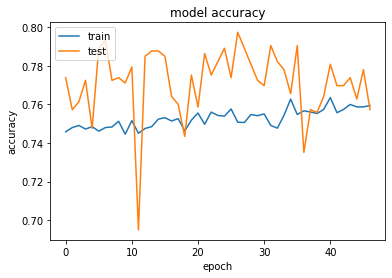

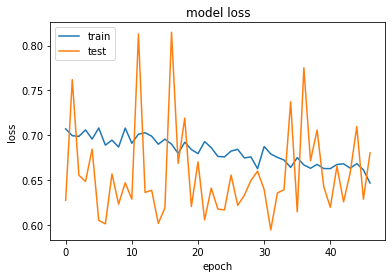

In [32]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### **Evaluate the model on the validation and test data.**


In [33]:
print('accuracy on the test set is',model.evaluate(x_test,y_test,batch_size=1)[1])

2003/2003 [==============================] - 5s 2ms/step
accuracy on the test set is 0.7314028956565152


Make the prediction on the validation dataset. Plot the confusion matrix and check the missclassified count of each type.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
# Predict the values from the validation dataset
y_validate_pred = model.predict(x_validate).round()

# Convert predictions classes to one hot vectors 
Y_pred_classes=to_categorical(y_validate_pred, num_classes = 7)

# Convert validation observations to one hot vectors
Y_true=to_categorical(y_validate, num_classes = 7)


# compute the confusion matrix
confusion_mtx = confusion_matrix(y_validate.argmax(axis=1),y_validate_pred.argmax(axis=1))

### **Plot the confusion matrix on the test dataset.**
 

Confusion matrix, without normalization
[[ 17   1   2   1   1   0   0]
 [ 18  12   1   1   3   0   1]
 [ 25   1  21   1  20   1   0]
 [  3   0   0   2   1   0   0]
 [ 44   1   9   0 443   2   3]
 [ 25   0  16   0  24  15   0]
 [  1   0   0   0   0   1   4]]


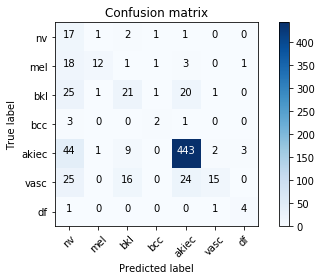

In [35]:
plot_confusion_matrix(confusion_mtx, classes = lesion_type_dict)

To see which category has most incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

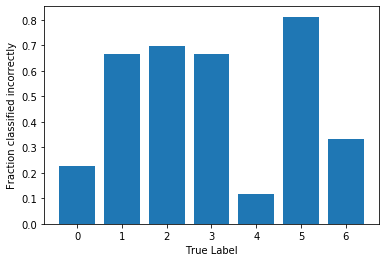

In [36]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')